## Step 1. Data Import and Initial Overview

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path



In [4]:
import pandas as pd

df = pd.read_csv("churn.csv")

ASSETS_DIR = Path("assets")
ASSETS_DIR.mkdir(parents=True, exist_ok=True)

def slugify(value: str) -> str:
    return value.lower().replace(" ", "_")

pd.set_option('display.max_columns', None)
df.head()



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [7]:
# The size of the data set 
df.shape


(10000, 14)

In [8]:
# Descriptive statistics of the data set
df.describe

<bound method NDFrame.describe of       RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumO

## Step 2. Data Cleaning

In [9]:
# Check for missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
#Check for duplicates
df.duplicated().sum()

np.int64(0)

### Removing Unused Features

To make the dataset cleaner and easier to interpret, we removed several columns that are not useful for machine learning.  
These variables serve only as identifiers or text labels and do not provide predictive value for customer churn.

- **RowNumber** – sequential index of each record, used only for ordering.  
- **CustomerId** – unique identifier for each customer, contains no behavioral information.  
- **Surname** – customer’s last name, a text field with too many unique values and no direct relation to churn.

By dropping these features, the dataset becomes more concise and focused on meaningful customer attributes that can influence churn behavior.

In [11]:
# Drop features that are identifiers or not useful for prediction
unused_features = ['RowNumber', 'CustomerId', 'Surname']

# Keep only columns that exist in the DataFrame
df = df.drop(columns=[col 
                      for col in unused_features if col in df.columns])
df.head()



,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
df.shape

(10000, 11)

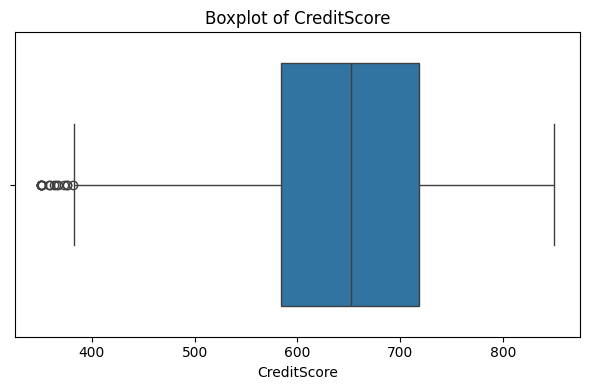

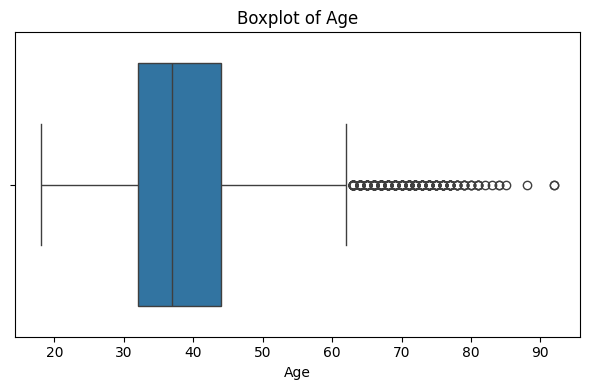

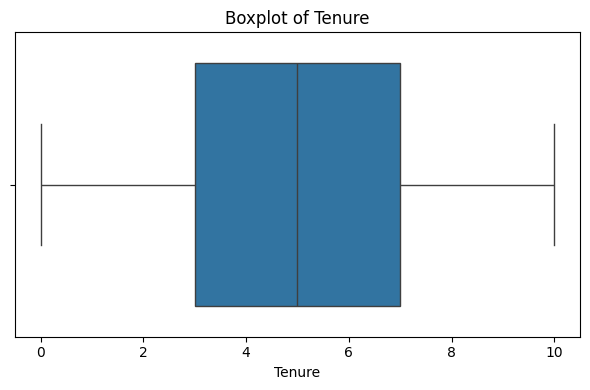

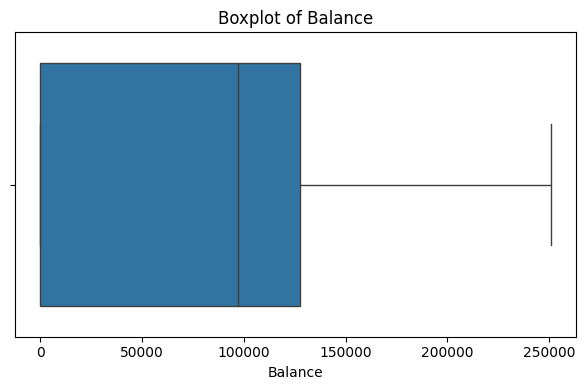

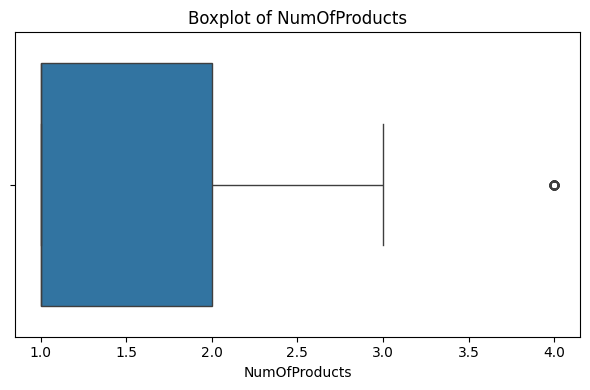

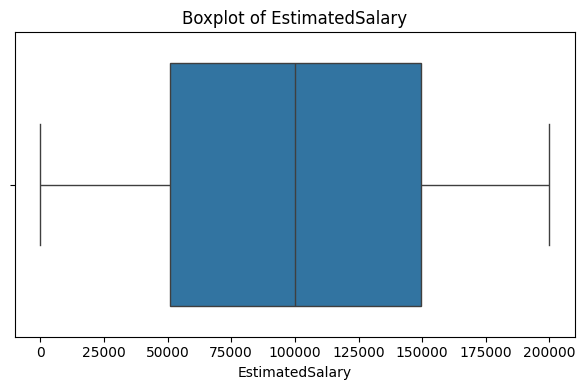

In [13]:
# Outlier Detection using Boxplots

numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    save_path = ASSETS_DIR / f"boxplot_{slugify(col)}.png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()



## Step 3. Univariate Analysis

### Purpose: Understand the distribution of each variable individually.
Numerical features → histogram or density plot

Categorical features → bar chart of frequency

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# If target column (Exited / Churn) exists, remove it from num_cols
target_col = 'Exited' 
if 'Exited' in df.columns:
    target_col = 'Exited'
else:
    target_col = 'Churn'
if target_col in num_cols:
    num_cols.remove(target_col)

### Numerical Features - Histogram

The numerical features included in this analysis are:

**CreditScore**, **Age**, **Tenure**, **Balance**, **NumOfProducts**, and **EstimatedSalary**.

These variables are continuous or integer-based and are visualized below using histograms to show their distributions.

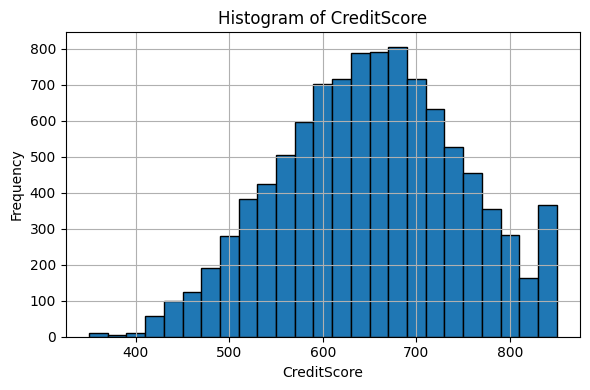

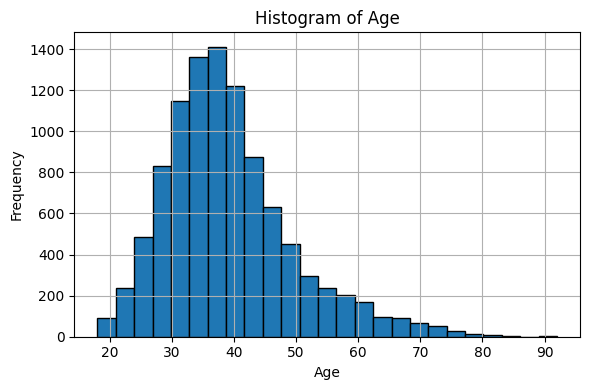

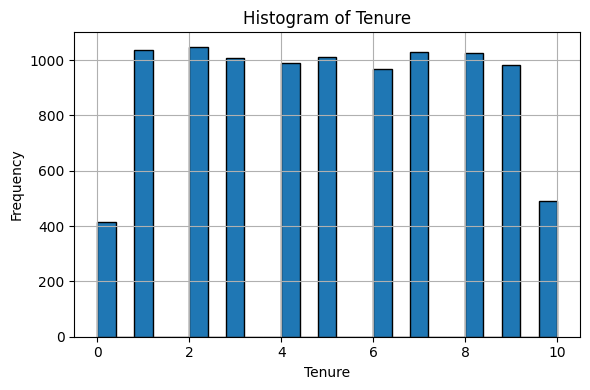

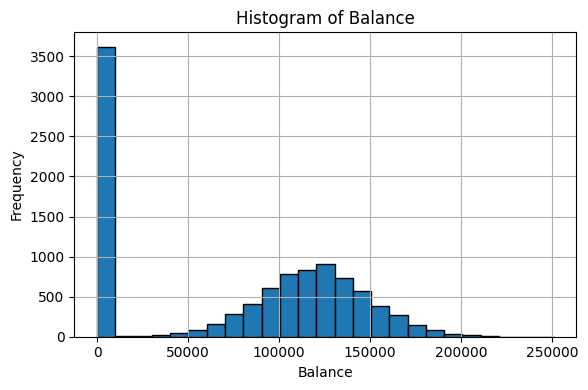

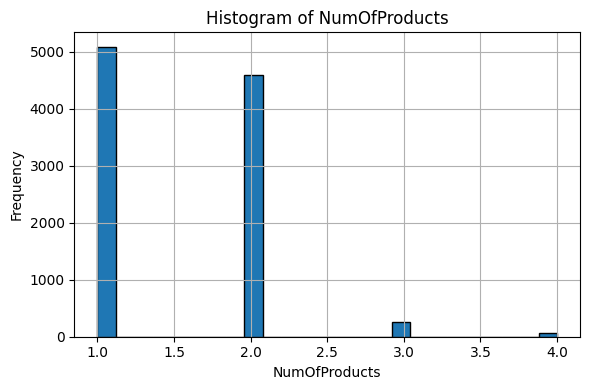

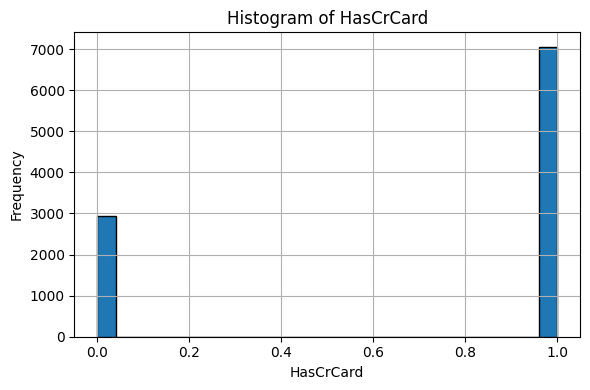

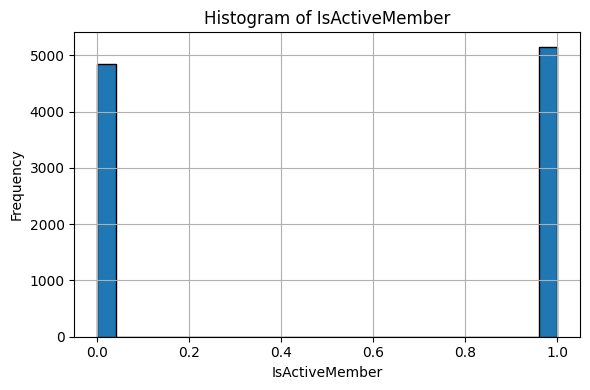

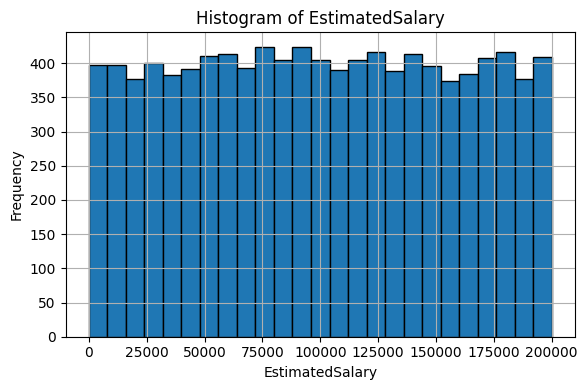

In [15]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col], bins=25, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    save_path = ASSETS_DIR / f"hist_{slugify(col)}.png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()



### Categorical Features - Bar Chart

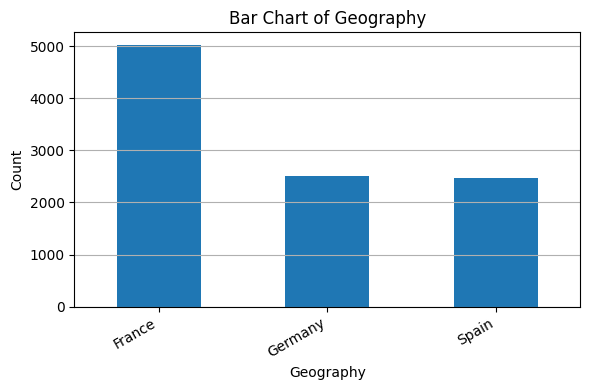

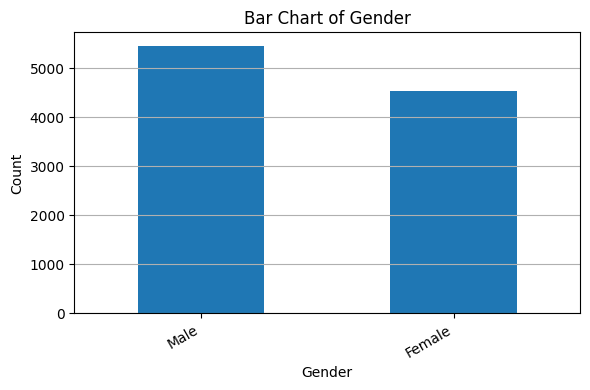

In [16]:
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Bar Chart of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    save_path = ASSETS_DIR / f"bar_{slugify(col)}.png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()



## Step 4. Bivariate Analysis

### Purpose: Examine relationships and correlations between features.

### Numerical vs Target (Boxplot)


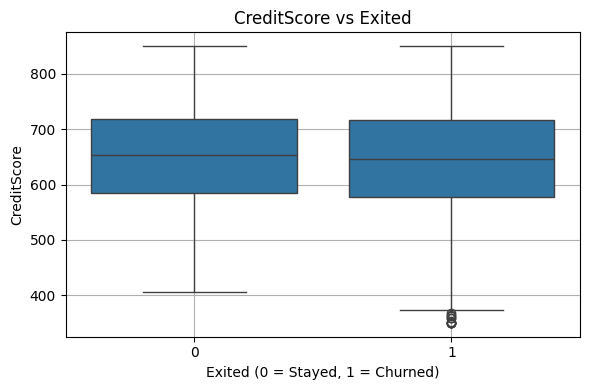

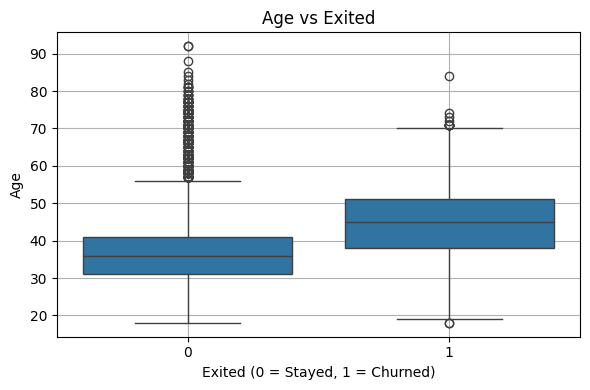

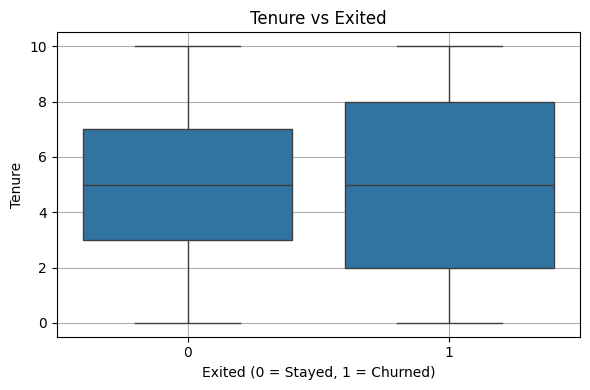

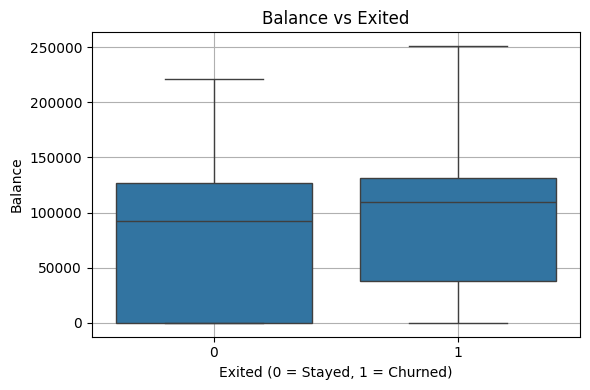

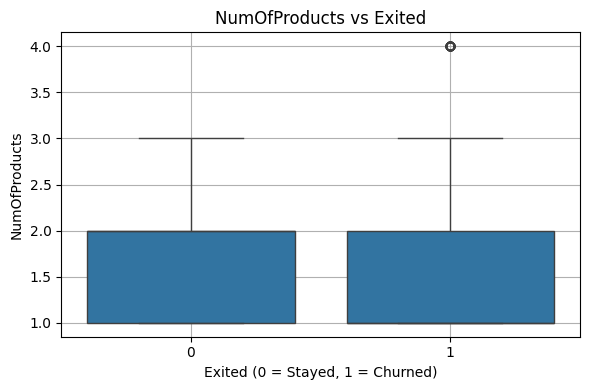

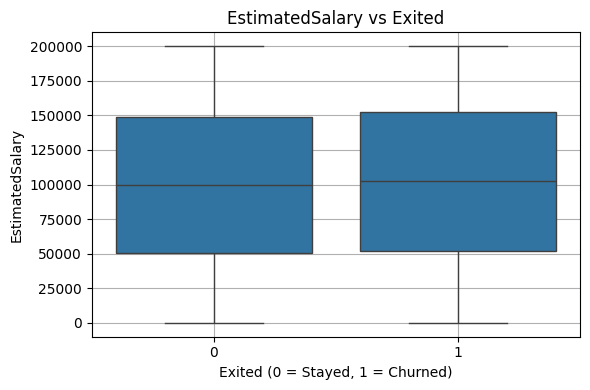

In [17]:
target_col = 'Exited'  # target variable
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target_col, y=col, data=df)
    plt.title(f'{col} vs {target_col}')
    plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    save_path = ASSETS_DIR / f"{slugify(col)}_vs_{slugify(target_col)}.png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()



### Categorical vs Target (Churn Rate)


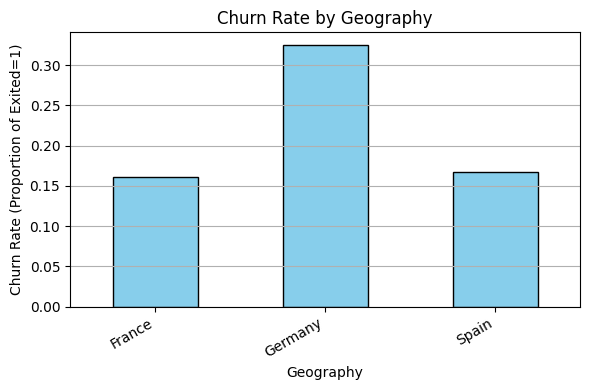

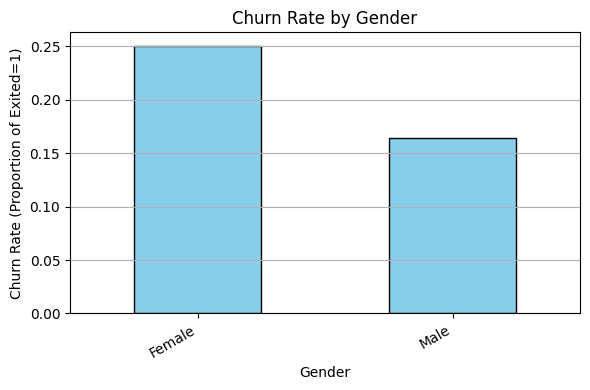

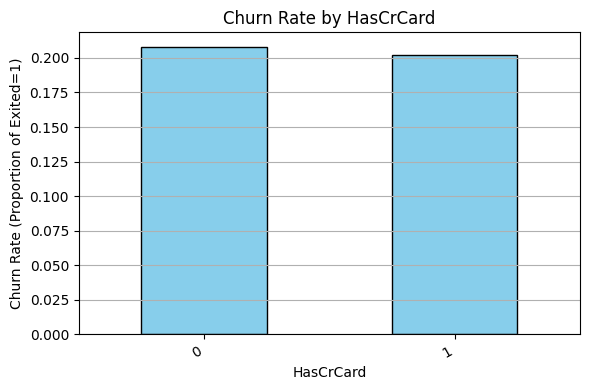

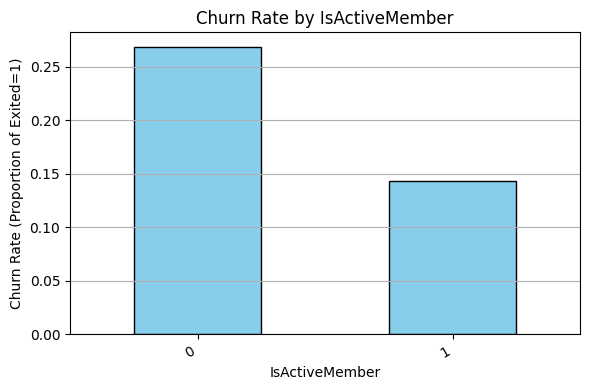

In [18]:
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

for col in cat_cols:
    churn_rate = df.groupby(col)['Exited'].mean()  # The average value is the churn rate
    plt.figure(figsize=(6, 4))
    churn_rate.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('Churn Rate (Proportion of Exited=1)')
    plt.xlabel(col)
    plt.grid(axis='y')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    save_path = ASSETS_DIR / f"churn_rate_by_{slugify(col)}.png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()



## Step 5. Multivariate Relationships
### Purpose： Examine relationships and correlations between numerical features 

In [19]:
# Compute the correlation matrix
corr_matrix = df[num_cols].corr()

In [20]:
# Display correlation values
display(corr_matrix)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.001384
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.007201
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.007784
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,0.012797
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.014204
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,1.000000


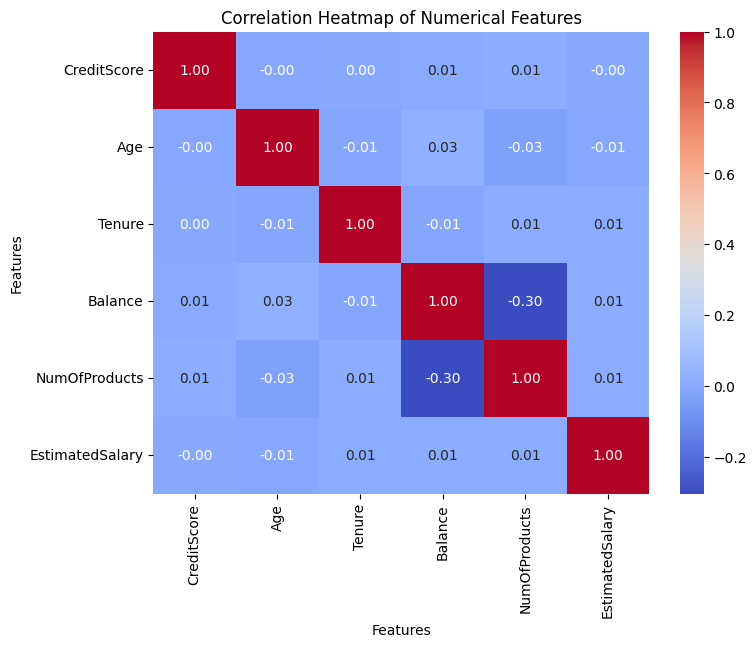

In [21]:
# Plot the correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

## Step 6. Class Imbalance Analysis

### Purpose: To examine whether the target variable (`Exited`) is balanced between churned and retained customers.

In [22]:
# Check target label distribution (counts and percentages)
label_counts = df['Exited'].value_counts()
label_percent = df['Exited'].value_counts(normalize=True) * 100

In [23]:
print("Label Distribution (Counts):")
print(label_counts)
print("\nLabel Distribution (Percentage):")
print(label_percent.round(2))

Label Distribution (Counts):
Exited
0    7963
1    2037
Name: count, dtype: int64

Label Distribution (Percentage):
Exited
0    79.63
1    20.37
Name: proportion, dtype: float64


In [24]:
df.to_csv("data/processed/churn_clean.csv", index=False)


OSError: Cannot save file into a non-existent directory: 'data/processed'